<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/cardio_train_interpretable_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:

from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [31]:
import io

data = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']),sep=';')  

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sn
import statistics
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from numpy import loadtxt
from xgboost import XGBClassifier


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [33]:

data.isnull().any()
data.head()
data.drop('id', axis=1, inplace=True)


In [35]:

# split data into X and y
x_train, x_test, y_train, y_test = train_test_split(data.drop('cardio', axis=1),
                                                        data['cardio'], test_size=0.2)

In [36]:
x_train.shape
y_train.shape
x_test.shape
y_train.shape

(56000,)

In [38]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [43]:
# evaluate predictions
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.81%
Accuracy: 73.81%


In [44]:
def get_distribution(col_name, data, model):
    x = data.copy()
    sequence = np.linspace(np.min(data[col_name]), np.max(data[col_name]), len(data[col_name]))
    y_dist = []
    ice_avgs = []
    for elem in sequence:
        x[col_name] = elem
        y_temp = model.predict(x)
        y_dist.append(np.mean(y_temp))
        
        ice_avgs.append(y_temp)
        
    return sequence, y_dist, ice_avgs

In [45]:
def plot_PDP(col_name, data, model, xlabel, ylabel):
    plt.figure(figsize = (10, 8))
    plt.grid()
    res = get_distribution(col_name, data, model)
    plt.plot(res[0], res[1], lw = 2, label = 'Trend')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(fontsize = 'large')
    plt.tight_layout()

In [46]:

def plot_ICE(col_name, data, model, xlabel, ylabel):
    res = get_distribution(col_name, data, model)
    x = res[0]
    ice_avgs = res[2]
    plt.figure(figsize = (12, 8))
    plt.grid()
    for row in range(len(ice_avgs[0])):
        ys = []
        for item in range(len(ice_avgs)):
            ys.append(ice_avgs[item][row])
        plt.plot(x, ys, c = 'black', alpha = 0.1)
        
    plt.plot(res[0], res[1], lw = 5, c = 'r', label = 'Avg. Trend (PDP)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(fontsize = 'large')
    plt.tight_layout()

In [74]:

def supervised_models_comparison(df: pd.DataFrame) ->pd.DataFrame:

    X, y = df.drop(columns='cardio'), df['cardio']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=119, stratify=y)

    # define the models along with the respective grid search parameters
    # logistic regression
    log_reg_clf = LogisticRegression()
    log_reg_params = {}
    # random forest
    rf_clf = RandomForestClassifier()
    rf_params = {'n_estimators': range(20, 36)}
    # naive bayes
    nb_clf = BernoulliNB()
    nb_params = {'alpha': [x * 0.005 for x in range(1, 10)]}


    # calculate metrics for various combinations 
    metrics_df = pd.DataFrame()
    for model_name, model, model_params in zip(['Logistic Regression', 'Random Forest', 'Naive Bayes'],
                                            [log_reg_clf, rf_clf, nb_clf],
                                            [log_reg_params, rf_params, nb_params]):
        print(f'Calculating results of {model_name} classifier')
        scaler = MinMaxScaler()
        edge_pipe = Pipeline([('scaling', scaler),
                            ('classifier', model)])
        # grid search 
        grid = GridSearchCV(model,
                        param_grid=model_params,
                        cv=5,
                        n_jobs=-1)
        grid.fit(X_train, y_train)
        # change the classifier in the pipe to the best classifier after frid search 
        edge_pipe = Pipeline([('scaling', scaler),
                            ('classifier',  grid.best_estimator_)])

        edge_pipe.fit(X_train, y_train)

        # results
        y_pred = edge_pipe.predict(X_test)
        results_df = evaluate_model(y_test, y_pred, labels_dict={0: 'Not_Cardio', 1: 'Cardio'}, model_name=model_name)
        metrics_df = metrics_df.append(results_df)

    return metrics_df

In [75]:
def evaluate_model(y_test, prediction, labels_dict, model_name) ->pd.DataFrame:
    # metrics
    accuracy = accuracy_score(y_test, prediction)
    recall = recall_score(y_test, prediction, average='macro')
    precision = precision_score(y_test, prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')

    print('Accuracy score: {:.3f}'.format(accuracy))
    print('Recall score: {:.3f}'.format(recall))
    print('Precision score: {:.3f}'.format(precision))
    print('F1 score: {:.3f}'.format(f1))

    print('Classification report:\n{}'.format(classification_report(y_test, prediction, target_names=list(labels_dict.values()))))

    # confusion matrix
    cm = confusion_matrix(y_test, prediction)

    df_cm = pd.DataFrame(cm, index=list(labels_dict.values()), columns=list(labels_dict.values()))
    plt.figure(figsize=(16,7))
    plt.title(f'Confusion matrix of {model_name} results')
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.0f')

    #plt.savefig('_matrix.png'.format(title))
    plt.show()

    df = pd.DataFrame(data={'metric': ['accuracy', 'recall', 'precision', 'f1'],
                            'score': [accuracy*100, recall*100, precision*100, f1*100],
                            'model': model_name}) 
    return df 

Calculating results of Logistic Regression classifier
Accuracy score: 0.651
Recall score: 0.651
Precision score: 0.652
F1 score: 0.651
Classification report:
              precision    recall  f1-score   support

  Not_Cardio       0.64      0.68      0.66      7004
      Cardio       0.66      0.62      0.64      6996

    accuracy                           0.65     14000
   macro avg       0.65      0.65      0.65     14000
weighted avg       0.65      0.65      0.65     14000



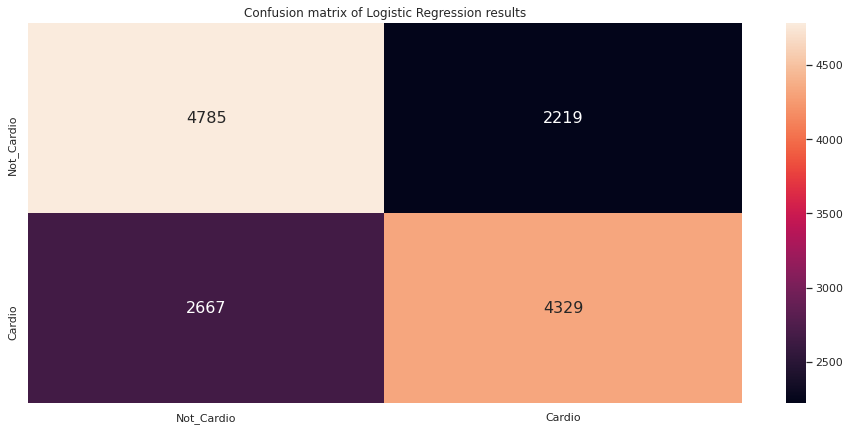

Calculating results of Random Forest classifier
Accuracy score: 0.709
Recall score: 0.709
Precision score: 0.709
F1 score: 0.709
Classification report:
              precision    recall  f1-score   support

  Not_Cardio       0.71      0.72      0.71      7004
      Cardio       0.71      0.70      0.71      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000



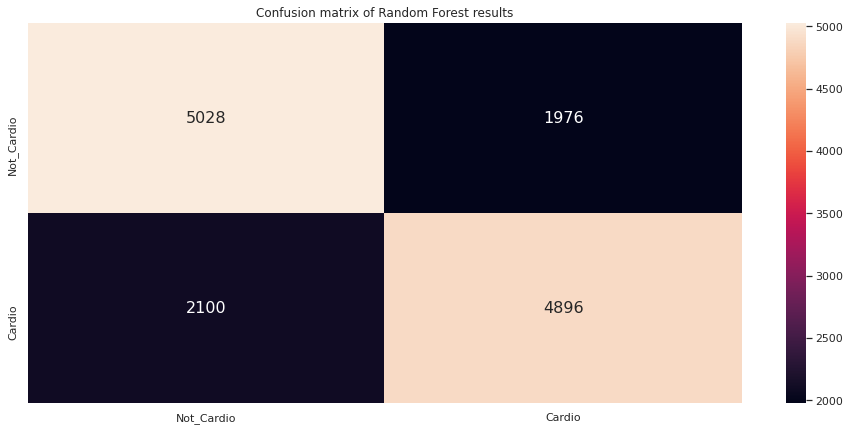

Calculating results of Naive Bayes classifier
Accuracy score: 0.593
Recall score: 0.593
Precision score: 0.611
F1 score: 0.577
Classification report:
              precision    recall  f1-score   support

  Not_Cardio       0.57      0.79      0.66      7004
      Cardio       0.65      0.39      0.49      6996

    accuracy                           0.59     14000
   macro avg       0.61      0.59      0.58     14000
weighted avg       0.61      0.59      0.58     14000



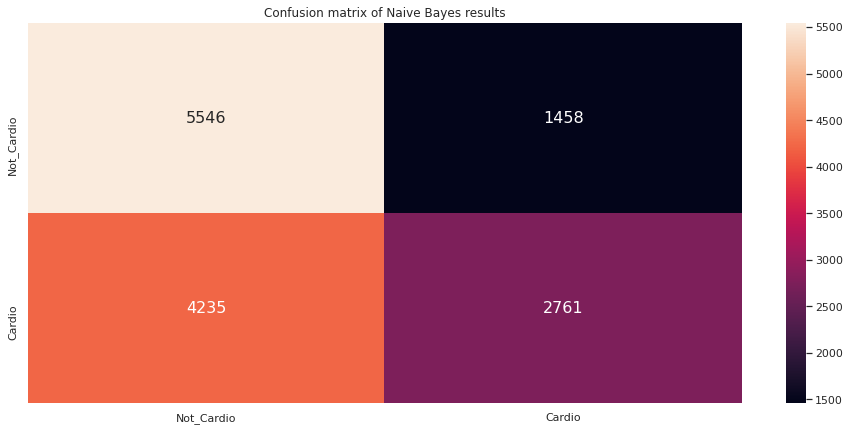

In [76]:
metrics_df = supervised_models_comparison(data)